## Project.5 Введение в машинное обучение
## (*Рекомендация тарифов*)

    (yandex_practicum by student@pavel_matushevskiy, Volgograd 2022)


### Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».  

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.  

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.   
Известно:  

сalls — количество звонков,  

minutes — суммарная длительность звонков в минутах,  

messages — количество sms-сообщений,  

mb_used — израсходованный интернет-трафик в Мб,  

is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### Шаг.  Импорт библиотек и настроек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plot_metric
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from plot_metric.functions import BinaryClassification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings

RANDOM_STATE = 42

PATH = '/datasets/users_behavior.csv'
PATH = 'users_behavior.csv'

labels=["smart","ultra"]

### Шаг 1. Импорт данных

In [2]:
df = pd.read_csv(PATH)
# посмотрим описание данных
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
# Посмотрим info: оценим признаки и наличие пропусков:
# имеем 4 числовых признака и 1 категориальный ("is_ultra")
#  странно что у признаков "messages" и "calls" категория - float, хотя явно должны быть целочисленными.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [5]:
# Проверим на наличие дубликатов:
# дубликаты лучше убирать, т.к. они негативно влияют нат метрики обученной модели.
df.duplicated().sum()

0

In [6]:
# проверим баланс классов таргета:
# Баланс не совсем равномерный, и это может повлиять на точность модели по классам
# (модель лучше выучит тот класс, которого больше)
# Это можно лечить весами классов при построении модели (используем этот вариант). 
# также можно использовать balanced_accuracy_score для рассчета сбалансированной метрики.
# или же сгенерировать новые данные для балансировки классов.
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

#### Промежуточный вывод
Мы ознакомились с данными, к ним особых претензий нет, пропусков нет, дубликатов нет, данные готовы к дальнейшей работе для обучения модели.

### 2. Разделение данных на выборки: train, validate, test

In [7]:
# нам нужны три выборки, будем разбивать на три группы train, validate, test
# в классическом соотношении: 60%-20%-20%
"""
train, validate, test = \
              np.split(df.sample(frac=1, random_state=RANDOM_STATE),
                      [int(.6*len(df)), int(.8*len(df))])
"""
# но лучше разбить на 80%-10%-10% (так модель будет иметь больше данных для обучения,
# и сможет лучше выявить закономерности) - проверено на практике,
# результаты метрик - лучше.
train, validate, test = \
    np.split(df.sample(frac=1, random_state=RANDOM_STATE),
             [int(.8*len(df)), int(.9*len(df))])

In [8]:
#Проверим баланс разбивки в итоге:
print(train.shape,validate.shape,test.shape)

(2571, 5) (321, 5) (322, 5)


### 3. Построение разных моделей, исследование результатов. 

#### 3.1. Формирование признаков и таргета для train, validate, test

In [9]:
# for train:
train_features = train.drop(['is_ultra'], axis=1)
train_target = train['is_ultra']
# for validate:
valid_features = validate.drop(['is_ultra'], axis=1)
valid_target = validate['is_ultra']
# for test:
test_features = test.drop(['is_ultra'], axis=1)
test_target = test['is_ultra']

По факту в нашем случае особого смысла в 3-ьей выборке (test) не было, т.к. данные validate и test "из одной бочки", поэтому датасет "test" ничего нового нам не покажет.  
Другое дело было бы - если бы в test были бы контрольные данные. 
Но для отработки общей классической процедуры обучения модели - будем использовать train, validate, test.

In [10]:
# смотрим распределение таргета по категориям в TRAIN: есть дисбаланс. Учтем его в дальнейшем
train['is_ultra'].value_counts(normalize=True)

0    0.694282
1    0.305718
Name: is_ultra, dtype: float64

/Users/paulmatus/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


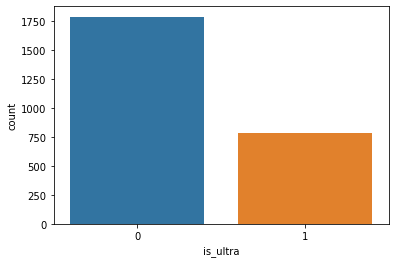

In [12]:
sns.countplot(train['is_ultra'])
plt.show()

/Users/paulmatus/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


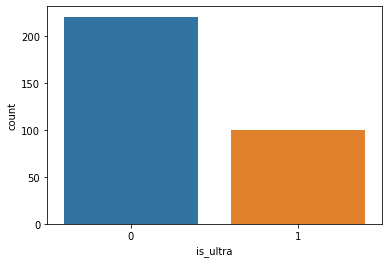

In [13]:
# смотрим распределение таргета по категориям в VALIDATE: есть дисбаланс.  
sns.countplot(validate['is_ultra'])
plt.show()

/Users/paulmatus/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


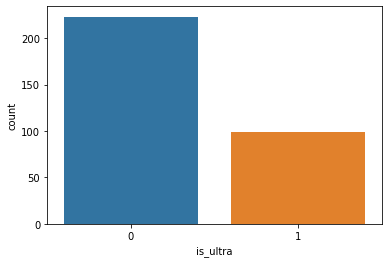

In [15]:
# смотрим распределение таргета по категориям в TEST:   есть дисбаланс.  
sns.countplot(test['is_ultra'])
plt.show()

#### 3.2. Модель дерево решений (decision tree)

In [16]:
# Построение моделей и поиск лучших начнем с простенькой модели - дерево решений.
# Будем строить модели с разной глубиной: от 2 до 14.
# и посмотрим на результаты:
# как видим наилучший результат  по метрике accuracy (85%) показала модель с глубиной 9.

for max_depth in range(2, 15):
    model_decision_tree = DecisionTreeClassifier(max_depth=max_depth,
                                                 class_weight={0: 1, 1: 1.2},
                                                 # class_weight = 'balanced',# bad result
                                                 random_state=RANDOM_STATE)
    model_decision_tree.fit(train_features, train_target)
    valid_predicted_tree = model_decision_tree.predict(valid_features)
    accuracy = accuracy_score(valid_target, valid_predicted_tree)
    modelName = 'Descision Tree; max_depth= ' + str(max_depth)

    print(modelName, '; accuracy =', accuracy)

Descision Tree; max_depth= 2 ; accuracy = 0.8068535825545171
Descision Tree; max_depth= 3 ; accuracy = 0.8161993769470405
Descision Tree; max_depth= 4 ; accuracy = 0.8099688473520249
Descision Tree; max_depth= 5 ; accuracy = 0.8255451713395638
Descision Tree; max_depth= 6 ; accuracy = 0.8161993769470405
Descision Tree; max_depth= 7 ; accuracy = 0.8255451713395638
Descision Tree; max_depth= 8 ; accuracy = 0.8286604361370716
Descision Tree; max_depth= 9 ; accuracy = 0.8504672897196262
Descision Tree; max_depth= 10 ; accuracy = 0.838006230529595
Descision Tree; max_depth= 11 ; accuracy = 0.8286604361370716
Descision Tree; max_depth= 12 ; accuracy = 0.8099688473520249
Descision Tree; max_depth= 13 ; accuracy = 0.8037383177570093
Descision Tree; max_depth= 14 ; accuracy = 0.8006230529595015


Лучший результат:  

    Descision Treet;  max_depth= 9 ; accuracy = 0.8411214953271028

Лучший результат (+class_weight):  

    Descision Treet;  max_depth= 9 ; accuracy = 0.8504672897196262
    
Параметр модели  class_weight = {0: 1, 1: 1.2} из-за дисбаланса классов по таргету дал прироста к точности модели (+1%)

In [17]:
# Посмотрим детальней результаты предсказаний лучшей модели:

model_decision_tree = DecisionTreeClassifier(max_depth=9,
                                             class_weight={0: 1, 1: 1.2},
                                             random_state=RANDOM_STATE)
model_decision_tree.fit(train_features, train_target)
valid_predicted_tree = model_decision_tree.predict(valid_features)
valid_predicted_tree

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

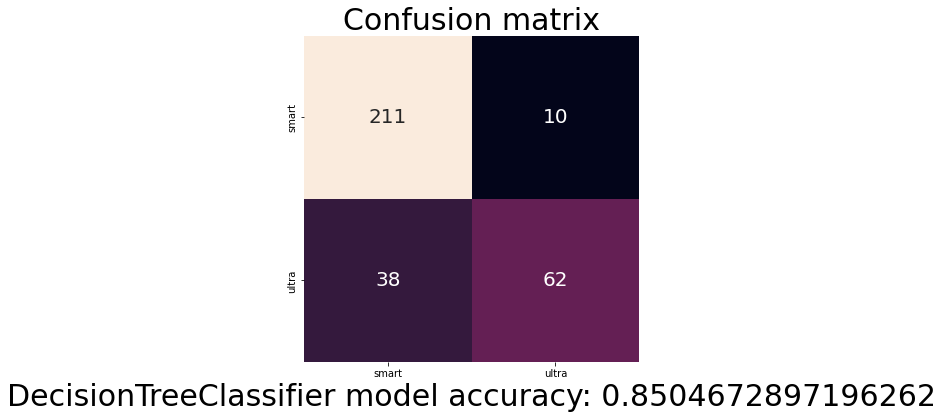

In [18]:
# построим confusion_matrix для оценки результатов:
plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_matrix(valid_target, valid_predicted_tree),
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt="1.0f",
            cbar=False,
            annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.xlabel(
    f"DecisionTreeClassifier model аccuracy: {accuracy_score(valid_target,valid_predicted_tree)}",
    fontsize=30)
plt.show()

In [19]:
# выведем отчет по матрице предсказаний и др важным метрикам:
print(classification_report(valid_target, valid_predicted_tree, target_names=labels))

              precision    recall  f1-score   support

       smart       0.85      0.95      0.90       221
       ultra       0.86      0.62      0.72       100

    accuracy                           0.85       321
   macro avg       0.85      0.79      0.81       321
weighted avg       0.85      0.85      0.84       321



In [20]:
# глянем на balanced accuracy (из-за того, что классы  таргета у нас неравные)
# странно, что  balanced accuracy выдало метрику хуже, чем просто accuracy. Хм...
print("balanced accuracy", balanced_accuracy_score(
    valid_target, valid_predicted_tree))
print("accuracy", accuracy_score(valid_target, valid_predicted_tree))

balanced accuracy 0.7873755656108598
accuracy 0.8504672897196262


Наша задача научить модель одинакого верно определять как тариф "Smart", так "ultra" (без предпочтений).  
Precision по тарифу "smart" - 85%. Неплохой результат классификации категории.  
Как видим, показатель Recall  по "ultra" категории низкий (62%), это означает, что модель плохо распознает тариф "ultra" (возможно из-за дисбаланса классов, хотя мы попытались это исправить).

DecisionTreeClassifier: ROC AUC=0.787


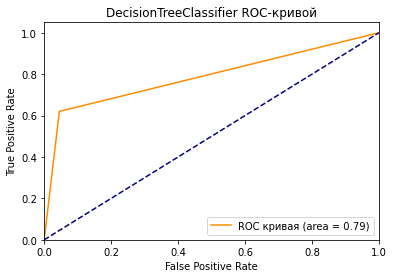

In [21]:
# рассчитаем ROC AUC значение:
lr_auc = roc_auc_score(valid_target, valid_predicted_tree)
print('DecisionTreeClassifier: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(valid_target, valid_predicted_tree)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DecisionTreeClassifier ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Именно показатель ROC_AUC является в такой ситуации наилучшим мерилом баланса успешности модели между умением определять классы.   
Чем значение ROC_AUC выше - тем наша модель лучше.    
Мы подобрали class_weight = {0: 1, 1: 1.2}  в качестве оптимального для наивысшего результата ROC_AUC для данной модели (78.7%)

#### 3.3. Модель случайный лес (random forest)

In [20]:
%%time
# построим модели "случайный лес" с кол-вом деревьев от 5 до 30 (с шагом 5)
# и глубиной дерева от 5 до 12,
# и посмотрим на результаты, а затем выберем наилучшую комбинацию гиперпараметров:

for estim in range(5, 30, 5):
    for max_depth in range(5, 12):
        model_random_forest = RandomForestClassifier(n_estimators=estim,
                                                     max_depth=max_depth, n_jobs=-1,
                                                     class_weight={
                                                         0: 1,
                                                         1: 1.2
                                                     },
                                                     random_state=RANDOM_STATE)
        model_random_forest.fit(train_features, train_target)
        valid_pred_rf = model_random_forest.predict(valid_features)

        accuracy = accuracy_score(valid_target, valid_pred_rf)

        modelName = "Random Forest; n_estimators = " + str(
            estim) + " ; max_depth= " + str(max_depth)
        print(modelName, '; accuracy =', accuracy)
    print()  # для разделения вывода

Random Forest; n_estimators = 5 ; max_depth= 5 ; accuracy = 0.7975077881619937
Random Forest; n_estimators = 5 ; max_depth= 6 ; accuracy = 0.838006230529595
Random Forest; n_estimators = 5 ; max_depth= 7 ; accuracy = 0.822429906542056
Random Forest; n_estimators = 5 ; max_depth= 8 ; accuracy = 0.8317757009345794
Random Forest; n_estimators = 5 ; max_depth= 9 ; accuracy = 0.8068535825545171
Random Forest; n_estimators = 5 ; max_depth= 10 ; accuracy = 0.8068535825545171
Random Forest; n_estimators = 5 ; max_depth= 11 ; accuracy = 0.8068535825545171

Random Forest; n_estimators = 10 ; max_depth= 5 ; accuracy = 0.8099688473520249
Random Forest; n_estimators = 10 ; max_depth= 6 ; accuracy = 0.822429906542056
Random Forest; n_estimators = 10 ; max_depth= 7 ; accuracy = 0.8255451713395638
Random Forest; n_estimators = 10 ; max_depth= 8 ; accuracy = 0.822429906542056
Random Forest; n_estimators = 10 ; max_depth= 9 ; accuracy = 0.8161993769470405
Random Forest; n_estimators = 10 ; max_depth= 10

Лучший результат:  

    Random Forest; n_estimators = 5 ; max_depth= 6 ; accuracy = 0.8317757009345794
    Random Forest; n_estimators = 30 ; max_depth= 6 ; accuracy = 0.8317757009345794

 В случае с  class_weight = {0: 1, 1: 1.2}, результат лучший:  
 
     Random Forest; n_estimators = 5 ; max_depth= 6 ; accuracy = 0.838006230529595  
 
     Random Forest; n_estimators = 25 ; max_depth= 7 ; accuracy = 0.838006230529595

#### Можно также поиск лучших гиперпараметров произвести через **GridSearch**.

In [21]:
from sklearn.model_selection import GridSearchCV
% % time

#iris = datasets.load_iris()
parameters = {'n_estimators': [5, 10, 15, 20, 25,
                               30, 35], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12]}
#svc = svm.SVC()
model_random_forest = RandomForestClassifier(
    class_weight={0: 1, 1: 1.2},
    random_state=RANDOM_STATE,)
clf = GridSearchCV(model_random_forest, parameters,
                   n_jobs=-1)
clf.fit(train_features, train_target)
#clf.fit(valid_target, valid_pred_rf)
# sorted(clf.cv_results_.keys())
# print(clf.predict(valid_features))
print(clf.best_params_)
clf.best_score_

{'max_depth': 10, 'n_estimators': 25}
CPU times: user 475 ms, sys: 188 ms, total: 663 ms
Wall time: 4.94 s


0.8105866797627591

Странно, что грид-сеарч выдал нам другие лучшие настройки, чем мы нашли наглаз.(ошибка?)

Посмотрим детальней на лучшую модель:

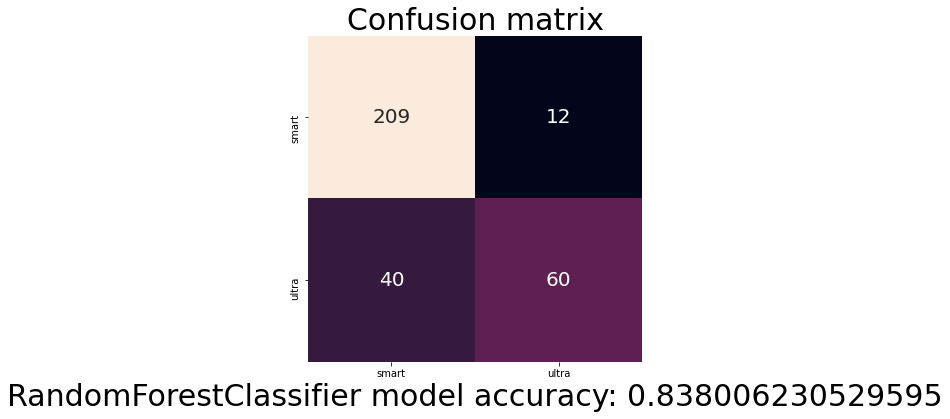

In [23]:
# Посмотрим детальней результаты предсказаний данной модели:
model_random_forest = RandomForestClassifier(n_estimators=5,
                                             max_depth=6,
                                             class_weight={
                                                 0: 1,
                                                 1: 1.2},
                                             random_state=RANDOM_STATE)
model_random_forest.fit(train_features, train_target)
valid_pred_rf = model_random_forest.predict(valid_features)

plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_matrix(valid_target, valid_pred_rf),
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt="1.0f",
            cbar=False,
            annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.xlabel(
    f"RandomForestClassifier model аccuracy: {accuracy_score(valid_target,valid_pred_rf)}",
    fontsize=30)
plt.show()

In [24]:
print(classification_report(valid_target, valid_pred_rf, target_names = labels)) 

              precision    recall  f1-score   support

       smart       0.84      0.95      0.89       221
       ultra       0.83      0.60      0.70       100

    accuracy                           0.84       321
   macro avg       0.84      0.77      0.79       321
weighted avg       0.84      0.84      0.83       321



In [25]:
# странно, что и здесь balanced accuracy выдал результат хуже, чем просто accuracy (ошибка?)
print("balanced accuracy", balanced_accuracy_score(valid_target, valid_pred_rf))
print("accuracy", accuracy_score(valid_target, valid_pred_rf))

balanced accuracy 0.7728506787330316
accuracy 0.838006230529595


Оценим результаты работы RandomForestClassifier:  

Precision по тарифу "smart" - 84%,  
показатель Recall  по "ultra" категории низкий (60%).  

RandomForestClassifier хуже отработал, чем DecisionTreeClassifier.

RandomForestClassifier: ROC AUC=0.77285


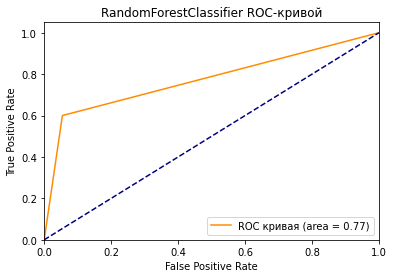

In [26]:
# рассчитаем ROC AUC значение:
lr_auc = roc_auc_score(valid_target, valid_pred_rf)
print('RandomForestClassifier: ROC AUC=%.5f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(valid_target, valid_pred_rf)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForestClassifier ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Оценим результаты работы RandomForestClassifier:  

ROC AUC=0.773  

RandomForestClassifier хуже отработал, чем DecisionTreeClassifier.

In [27]:
log_loss(valid_target, valid_pred_rf)

5.595096472599745

#### 3.4. Модель логистическая регрессия (LogisticRegression)

In [28]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
model_logistic_regression = LogisticRegression(
    class_weight={0: 1, 1: 1.2},
    random_state=RANDOM_STATE
)
model_logistic_regression.fit(train_features, train_target)
valid_pred_lr = model_logistic_regression.predict(valid_features)
accuracy = accuracy_score(valid_target, valid_pred_lr)
print(modelName, '; accuracy =', accuracy)
print("balanced accuracy:", balanced_accuracy_score(valid_target, valid_pred_lr))

Random Forest; n_estimators = 25 ; max_depth= 11 ; accuracy = 0.7725856697819314
balanced accuracy: 0.6486877828054298


 LogisticRegression результат:  
 
     Random Forest; n_estimators = 25 ; max_depth= 11 ; accuracy = 0.6978193146417445

 LogisticRegression  случае с  class_weight  результат улучшается:  
 
     Random Forest; n_estimators = 25 ; max_depth= 11 ; accuracy = 0.7725856697819314

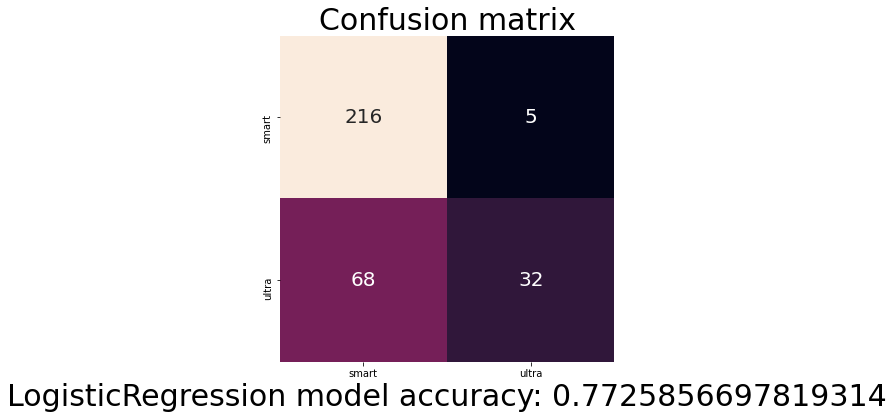

In [29]:
plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_matrix(valid_target, valid_pred_lr),
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt="1.0f",
            cbar=False,
            annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.xlabel(
    f"LogisticRegression model аccuracy: {accuracy_score(valid_target,valid_pred_lr)}",
    fontsize=30)
plt.show()

In [30]:
print(classification_report(valid_target, valid_pred_lr, target_names=labels))

              precision    recall  f1-score   support

       smart       0.76      0.98      0.86       221
       ultra       0.86      0.32      0.47       100

    accuracy                           0.77       321
   macro avg       0.81      0.65      0.66       321
weighted avg       0.79      0.77      0.73       321



Оценим результаты работы  модели LogisticRegression:  

Precision по тарифу "smart" - 76%, показатель Recall  по "ultra" категории очень низкий (32%).
LogisticRegression отработал хуже, чем RandomForestClassifier и DecisionTreeClassifier.

RandomForestClassifier: ROC AUC=0.649


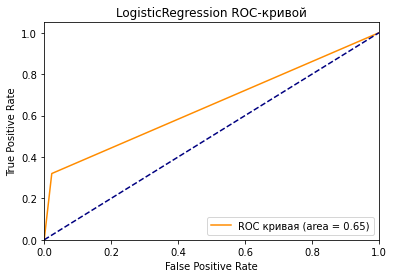

In [31]:
# рассчитаем ROC AUC значение:
lr_auc = roc_auc_score(valid_target, valid_pred_lr)
print('RandomForestClassifier: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(valid_target, valid_pred_lr)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogisticRegression ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Оценим результаты работы LogisticRegression:  

ROC AUC=0.649

LogisticRegression дает результат мало лучше, чем случайность (65%)

#### Промежуточный вывод

- Лучший результат в точности показала модель Дерево Решений с параметрами: max_depth= 9
- Худший результат в точночти показала логистическая регрессия
- Довольно неплохо показало себя Случайный лес, при чем глубины 6 было достаточно и кол-во деревьев - 5.
- как и подозревали, дисбаланс классов по таргету оказывает влияние на результат обучения модели. Параметр class_weight способен улучшить метрики (+1+2%)

#### 3.5. Модель SVM 

In [32]:
model_svm = svm.SVC(class_weight={0: 1, 1: 1.4}, random_state=RANDOM_STATE)
model_svm.fit(train_features, train_target)
valid_predict_svm = model_svm.predict(valid_features)
print("balanced accuracy",
      balanced_accuracy_score(valid_target, valid_predict_svm))
print("accuracy", accuracy_score(valid_target, valid_predict_svm))

balanced accuracy 0.6673755656108598
accuracy 0.7757009345794392


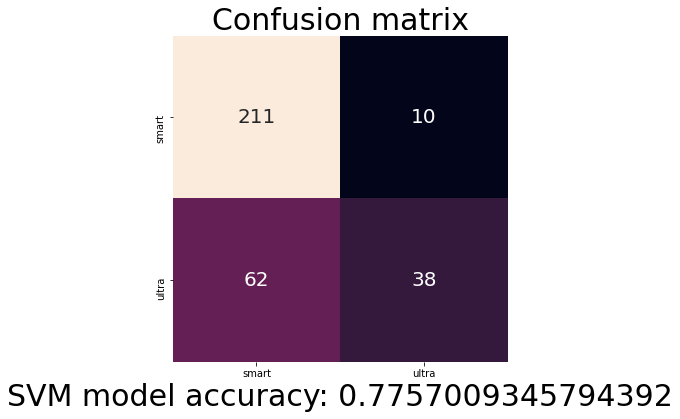

In [33]:
plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_matrix(valid_target, valid_predict_svm),
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt="1.0f",
            cbar=False,
            annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.xlabel(
    f"SVM model аccuracy: {accuracy_score(valid_target,valid_predict_svm)}",
    fontsize=30)
plt.show()

В связи с низкими показателями "accuracy" и "balanced accuracy" не стал более глубоко анализировать модель.

####  3.5. Модель KNeighborsClassifier

In [34]:
model_neigh = KNeighborsClassifier(n_neighbors=7)
model_neigh.fit(train_features, train_target)
valid_predict_neigh = model_neigh.predict(valid_features)
print("balanced accuracy", balanced_accuracy_score(
    valid_target, valid_predict_neigh))
print("accuracy", accuracy_score(valid_target, valid_predict_neigh))

balanced accuracy 0.7046380090497738
accuracy 0.8006230529595015


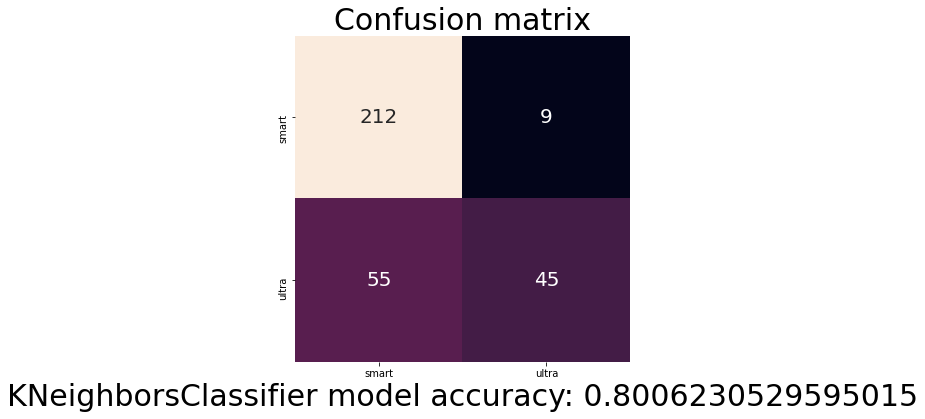

In [35]:
plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_matrix(valid_target, valid_predict_neigh),
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt="1.0f",
            cbar=False,
            annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.xlabel(
    f"KNeighborsClassifier model аccuracy: {accuracy_score(valid_target,valid_predict_neigh)}",
    fontsize=30)
plt.show()

В связи с низкими показателями "accuracy" и "balanced accuracy" не стал более глубоко анализировать модель.

### 4. Проверьте модель на тестовой выборке

In [36]:
# проверим наилучшую модель на тестовых данных
model = DecisionTreeClassifier(max_depth=9, class_weight={0: 1, 1: 1.2},
                               random_state=RANDOM_STATE)
model.fit(train_features, train_target)
test_predicted = model.predict(test_features)
print('Test accuracy:', accuracy_score(test_target, test_predicted))
print("balanced accuracy:", balanced_accuracy_score(test_target, test_predicted))

Test accuracy: 0.7888198757763976
balanced accuracy: 0.6986909453277166


In [37]:
# из интереса проверим точность модели на исходных данных
train_predicted = model.predict(train_features)
print('Train accuracy:', accuracy_score(train_target, train_predicted))
print("balanced accuracy:", balanced_accuracy_score(
    train_target, train_predicted))

Train accuracy: 0.8673667833527811
balanced accuracy: 0.8001678534009024


#### Предварительный вывод

Мы получили хорошую точность моделей (все модели уложились в требования по accuracy (75%). Наилучшими оказались модели: Дерево решений и  Случайный лес.
При этом, учитывая, что на исходных данных accuracy не ушли за 90%, можно оценить фактор переобучения как не сильно критичный для нашей модели. Скорее можно говорить о недообучении модели.


<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера🤔:</b> А почему ты считаешь, что звоночком об оверфиттинге является рубеж в 90%? Разница между в точности между обучающей выборкой и тестовой 9% - это много и свидетельствует о не очень адекватной работе модели
</div>

### 5. Проверка модели на адекватность (бонус) 

Для проверки результата сделаем Cross validation для лучшей нашей модели на всех данных, чтобы убедиться, что результаты модели не случайны (из-за неравномерного распределения по качеству среди train, validate, test). 

In [38]:
# DecisionTreeClassifier
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

model_decision_tree = DecisionTreeClassifier(max_depth=9,
                                             class_weight={0: 1, 1: 1.4},
                                             random_state=RANDOM_STATE)

print(cross_val_score(model_decision_tree, features, target, cv=20))
print("Среднее значение accuracy на Cross-val:", cross_val_score(model_decision_tree,
                                                                 features, target, cv=20).mean())

[0.81987578 0.77639752 0.79503106 0.81987578 0.72049689 0.80745342
 0.77018634 0.80124224 0.79503106 0.80745342 0.8136646  0.80124224
 0.78881988 0.80124224 0.78125    0.83125    0.81875    0.8125
 0.75       0.8375    ]
Среднее значение accuracy на Cross-val: 0.7974631211180124


In [39]:
# RandomForestClassifier
model_random_forest = RandomForestClassifier(n_estimators=5,
                                             max_depth=6,
                                             class_weight={
                                                 0: 1,
                                                 1: 1.2},
                                             random_state=RANDOM_STATE)

print(cross_val_score(model_random_forest, features, target, cv=20))
print("Среднее значение accuracy на Cross-val:", cross_val_score(model_random_forest,
                                                                 features, target, cv=20).mean())

[0.83850932 0.81987578 0.7826087  0.8136646  0.77018634 0.78881988
 0.74534161 0.82608696 0.80124224 0.82608696 0.80745342 0.80124224
 0.8136646  0.79503106 0.78125    0.8        0.825      0.8
 0.80625    0.83125   ]
Среднее значение accuracy на Cross-val: 0.8036781832298135


In [40]:
# KNeighborsClassifier
model_neigh = KNeighborsClassifier(n_neighbors=7)
print(cross_val_score(model_neigh, features, target, cv=20))
print("Среднее значение accuracy на Cross-val:", cross_val_score(model_neigh,
                                                                 features, target, cv=20).mean())

[0.8136646  0.7826087  0.73913043 0.79503106 0.76397516 0.80124224
 0.76397516 0.75776398 0.76397516 0.77018634 0.72670807 0.76397516
 0.77639752 0.78881988 0.71875    0.74375    0.775      0.7625
 0.7875     0.78125   ]
Среднее значение accuracy на Cross-val: 0.7688101708074534


Промежуточный вывод:
    согласно Cross-val проверке RandomForestClassifier показала лучший результат:
        Среднее значение accuracy на Cross-val: 0.8036781832298135

In [41]:
from sklearn.dummy import DummyClassifier

# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(
    train_features, train_target)
dummy_pred = dummy.predict(valid_features)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))
# checking accuracy
print('Test accuracy: ', accuracy_score(valid_target, dummy_pred))

Unique predicted labels:  [0]
Test accuracy:  0.6884735202492211


In [42]:
# for train:
train_features = train.drop(['is_ultra'], axis=1)
train_target = train['is_ultra']
# for validate:
valid_features = validate.drop(['is_ultra'], axis=1)
valid_target = validate['is_ultra']
# for test:
test_features = test.drop(['is_ultra'], axis=1)
test_target = test['is_ultra']

In [43]:
# уточним кол-во образцов по классам:
train['is_ultra'].value_counts()

0    1785
1     786
Name: is_ultra, dtype: int64

In [44]:
from sklearn.utils import resample

# concatenate our training data back together
data = pd.concat([train_features, train_target], axis=1)

# separate minority and majority classes
not_fraud = data[data['is_ultra'] == 0]
fraud = data[data['is_ultra'] == 1]

# upsample minority
fraud_upsampled = resample(
    fraud,
    replace=True,  # sample with replacement
    n_samples=len(not_fraud),  # match number in majority class
    random_state=27)  # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled['is_ultra'].value_counts()

0    1785
1    1785
Name: is_ultra, dtype: int64

In [45]:
upsampled

,calls,minutes,messages,mb_used,is_ultra
506,46.0,338.60,35.0,11428.54,0
2513,39.0,242.71,0.0,20480.11,0
354,39.0,258.02,0.0,19998.80,0
1642,87.0,583.02,1.0,11213.97,0
2706,86.0,544.49,68.0,16555.89,0
...,...,...,...,...,...
2778,2.0,2.00,157.0,25482.17,1
1195,66.0,462.58,100.0,11846.31,1
481,158.0,1168.06,103.0,20018.79,1
1477,98.0,703.16,4.0,25391.67,1


Теперь обучим модель на этих данных:

In [49]:
# trying DecisionTreeClassifier  again with the balanced dataset
train_target_bal = upsampled['is_ultra']
train_features_bal = upsampled.drop(['is_ultra'], axis=1)

for max_depth in range(2, 15):
    model_decision_tree = DecisionTreeClassifier(
        max_depth=max_depth,
        # class_weight = {0: 1, 1: 1.2},
        random_state=42)
    model_decision_tree.fit(train_features_bal, train_target_bal)
    valid_predicted_tree = model_decision_tree.predict(valid_features)
    accuracy = accuracy_score(valid_target, valid_predicted_tree)
    modelName = 'Descision Tree; max_depth= ' + str(max_depth)

    print(modelName, '; accuracy =', accuracy)

Descision Tree; max_depth= 2 ; accuracy = 0.8068535825545171
Descision Tree; max_depth= 3 ; accuracy = 0.8161993769470405
Descision Tree; max_depth= 4 ; accuracy = 0.7289719626168224
Descision Tree; max_depth= 5 ; accuracy = 0.735202492211838
Descision Tree; max_depth= 6 ; accuracy = 0.8068535825545171
Descision Tree; max_depth= 7 ; accuracy = 0.7694704049844237
Descision Tree; max_depth= 8 ; accuracy = 0.7601246105919003
Descision Tree; max_depth= 9 ; accuracy = 0.7819314641744548
Descision Tree; max_depth= 10 ; accuracy = 0.7538940809968847
Descision Tree; max_depth= 11 ; accuracy = 0.7538940809968847
Descision Tree; max_depth= 12 ; accuracy = 0.7725856697819314
Descision Tree; max_depth= 13 ; accuracy = 0.7632398753894081
Descision Tree; max_depth= 14 ; accuracy = 0.7881619937694704


In [51]:
model_decision_tree = DecisionTreeClassifier(max_depth=9,
                                             class_weight={0: 1, 1: 1.2},
                                             random_state=RANDOM_STATE)
model_decision_tree.fit(train_features_bal, train_target_bal)
valid_predicted_tree = model_decision_tree.predict(valid_features)
print("balanced accuracy", balanced_accuracy_score(
    valid_target, valid_predicted_tree))
print("accuracy", accuracy_score(valid_target, valid_predicted_tree))

balanced accuracy 0.6968778280542987
accuracy 0.7258566978193146


####  Промежуточный вывод:  
мы предприняли попытку "выравнять классы", однако это не дало существенных улучшений по метрикам модели.

## Итоговый вывод

Мы провели хоть и небольшую, но важную работу.
- Мы изучили наши данные и привели типы к нужным значениям
- Создали три выборки по которым обучили и проверили нашу модель в пропорции 80% - 10% - 10%
 - Мы исследовали 5 различные моделей с разными значениями гиперпараметров (Дерево решений, Случайный лес, Логистическую регрессию, SVM опорных векторов и Ближайших соседей)
- Мы определили лучшую модель и параметры для нее, измерив и сравнив точность наших предсказаний на валидационной выборке (в нашем случае лучший результат показал дерево решений с глубиной - 9)
- Мы проверили нашу модель на тестовых данных и полученные метрики оказались близко к метрикам на валидационной выборке. При этом  для нашей модели присутствует недообучение, но не критично.
- Дополнительно мы проверили модель на адекватность и наша модель показала хорошие результаты в сравнении со результатами кросс-валидации.

Отдел маркетинга "Мегалайн" может жить спокойно - мы создали для него модель,  которая позволит предлагать изменение тарифа заинтересованным в этом клиентам (по крайней мере с вероятностью 80%+)